In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Running from the root makes things easy

In [2]:
%cd ../..

/media/yasen/storage/studies/uoe/mlp/sem2/mlp-03


In [3]:
from src.datautils.sandia import SandiaDataProvider

# Setup data provider

In [4]:
train_batch_size = 32
test_batch_size = 3

# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('datasets/mnist', train=True, download=True,
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=train_batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('datasets/mnist', train=False, transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=test_batch_size, shuffle=True)

train_data = SandiaDataProvider(which_set='train',
                                  dataset_home='datasets/sandia/',
                                  img_size=28)
test_data = SandiaDataProvider(which_set='test',
                                  dataset_home='datasets/sandia/',
                                  img_size=28,
                                  normalize_mean=train_data.normalize_mean,
                                  normalize_sd=train_data.normalize_sd)
# Reload these every time you start an epoch
train_loader = train_data.get_batch_iterator(train_batch_size)
test_loader = test_data.get_batch_iterator(test_batch_size)

# Define models

In [12]:
lr = 0.01
momentum = 0.5
cuda = True
latent_size = 10

from src.autoencoders import PCA_autoencoder

class ReasoningAgent(nn.Module):
    def __init__(self, latent_size):
        super(ReasoningAgent, self).__init__()
        self.latent_size = latent_size
        self.affine = nn.Linear(latent_size*8, latent_size)
        
    def forward(self, latent_vectors):
        # Reshape num_batch, num_im, latent_size -> num_batch, num_im * latent_size
        num_batch, num_im, latent_size = latent_vectors.size()
        reshaped_latent = latent_vectors.view(num_batch, num_im * latent_size)
        latent_prediction = self.affine(reshaped_latent)
        return latent_prediction
    
class Architecture(nn.Module):
    def __init__(self, latent_size):
        super(Architecture, self).__init__()
        self.latent_size = latent_size
        self.autoencoder = PCA_autoencoder(self.latent_size)
        self.reasoning_agent = ReasoningAgent(self.latent_size)
        
    def forward(self, inputs):
        # inputs and choices are num_batch, im_width, im_height, num_im
        num_batch, im_width, im_height, num_im = inputs.size()
        
        # These are in the shape <num_questions, imsize, imsize, 16(8Q + 8A)> - transpose and reshape so that they are
        # in the shape <num_images, img_size **2 >
        flattened_inputs = inputs.permute(0, 3, 1, 2).contiguous().view(-1, im_width * im_height)

        # Get latent vectors
        latent_inputs = self.autoencoder.encode(flattened_inputs.cpu().data.numpy())
        
        # Convert to Torch variable
        latent_inputs = torch.from_numpy(latent_inputs).float()
        if cuda:
            latent_inputs = latent_inputs.cuda()
        latent_inputs = Variable(latent_inputs)
        
        # Reshape to regain structure of problem
        latent_inputs = latent_inputs.view(num_batch, num_im, self.latent_size)
        
        # Get latent prediction
        latent_prediction = self.reasoning_agent(latent_inputs)
        
        return latent_prediction
    
model = Architecture(100)
# model = Autoencoder(10)
if cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Train models

In [13]:
log_interval = 50
losses = []
            
def train(epoch, matrix_types=None):
    train_data = SandiaDataProvider(which_set='train',
                                  dataset_home='datasets/sandia/',
                                  img_size=28,
                                  matrix_types=matrix_types)
    train_loader = train_data.get_batch_iterator(train_batch_size)
    
    # Pretrain the PCA encoder
    X = train_data.inputs.transpose(3, 0, 1, 2).reshape(-1, 28 * 28)
    model.autoencoder.train(X)
    model.train()
    # Get new gen object at every epoch
    for batch_idx, (data, labels) in enumerate(train_loader):
        batch_size = len(data)
        data, labels = torch.from_numpy(data).float(), torch.from_numpy(labels).long()
        if cuda:
            data, labels = data.cuda(), labels.cuda()
        data, labels = Variable(data), Variable(labels)
        optimizer.zero_grad()
        latent_predictions = model(data[:, :, :, :8])
        choices = data[:, :, :, 8:].permute(3, 0, 1, 2)
        indices = torch.from_numpy(np.arange(len(data))).long()
        if cuda:
            indices = indices.cuda()
        targets = choices[labels.data, indices].squeeze()
        # Get latent representations of targets
        targets = targets.view(batch_size, -1)
        latent_targets = model.autoencoder.encode(targets.cpu().data.numpy())
        # Convert to Torch variable
        latent_targets = torch.from_numpy(latent_targets).float()
        if cuda:
            latent_targets = latent_targets.cuda()
        latent_targets = Variable(latent_targets)
        loss = F.mse_loss(latent_predictions, latent_targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
        if batch_idx % log_interval == 0:
            print('Train Epoch: {0} Loss: {1:.6f}'.format(epoch, loss.data[0]))

def test(matrix_types=None):
    model.eval()
    test_loss = 0
    correct = 0
    img_size = 28
    # Get a fresh generator object
    test_data = SandiaDataProvider(which_set='test',
                                  dataset_home='datasets/sandia/',
                                  img_size=img_size,
                                  matrix_types=matrix_types,
                                  normalize_mean=train_data.normalize_mean,
                                  normalize_sd=train_data.normalize_sd)
    test_loader = test_data.get_batch_iterator(test_batch_size)
    for batch_idx, (data, labels) in enumerate(test_loader):
        batch_size = len(data)
        data, labels = torch.from_numpy(data).float(), torch.from_numpy(labels).long()
        if cuda:
            data, labels = data.cuda(), labels.cuda()
        data, labels = Variable(data), Variable(labels)
        optimizer.zero_grad()
        latent_predictions = model(data[:, :, :, :8])
        choices = data[:, :, :, 8:].permute(3, 0, 1, 2)
        indices = torch.from_numpy(np.arange(len(data))).long()
#         import pdb
#         pdb.set_trace()
        choices_to_feed_to_pca = choices.cpu().data.numpy().reshape(8, batch_size, img_size ** 2).reshape(-1, img_size ** 2)
        latent_choices = model.autoencoder.encode(choices_to_feed_to_pca).reshape(8, batch_size, -1)
       
        if cuda:
            indices = indices.cuda()
        targets = choices[labels.data, indices].squeeze()
        # Get latent representations of targets
        targets = targets.view(batch_size, -1)
        latent_targets = model.autoencoder.encode(targets.cpu().data.numpy())
        # Convert to Torch variable
        latent_targets = torch.from_numpy(latent_targets).float()
        if cuda:
            latent_targets = latent_targets.cuda()
            
        
        latent_targets = Variable(latent_targets)
        test_loss += F.mse_loss(latent_predictions, latent_targets, size_average=False).data[0]
        
        sq_err = (latent_choices - latent_predictions.cpu().data.numpy()) ** 2
        tot_sq_err = sq_err.sum(2)
        
        preds = np.argmin(tot_sq_err, 0)
#         import pdb
#         pdb.set_trace()
        correct += np.sum(preds == labels.cpu().data.numpy())
        
#         residuals = latent_targets - latent_predictions
#         squared_error = residuals ** 2
#         pred = squared_error.data.min(1, keepdim=True)[1] # get the index of the min mse choice
#         correct += pred.eq(labels.data.view_as(pred)).cpu().sum()

    test_loss /= test_data.size()
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_data.size(),
        100. * correct / test_data.size()))

In [14]:
epochs = 20
for epoch in range(1, epochs + 1):
    train(epoch)
#     test(['1_layer'])    
#     train_autoencoder_only(epoch)

Train Epoch: 1 Loss: 8.177875
Train Epoch: 2 Loss: 4.461903
Train Epoch: 3 Loss: 3.933215
Train Epoch: 4 Loss: 3.614869
Train Epoch: 5 Loss: 3.381038
Train Epoch: 6 Loss: 3.192949
Train Epoch: 7 Loss: 3.034855
Train Epoch: 8 Loss: 2.898807
Train Epoch: 9 Loss: 2.779972
Train Epoch: 10 Loss: 2.675024
Train Epoch: 11 Loss: 2.581498
Train Epoch: 12 Loss: 2.497500
Train Epoch: 13 Loss: 2.421537
Train Epoch: 14 Loss: 2.352416
Train Epoch: 15 Loss: 2.289175
Train Epoch: 16 Loss: 2.231026
Train Epoch: 17 Loss: 2.177321
Train Epoch: 18 Loss: 2.127520
Train Epoch: 19 Loss: 2.081170
Train Epoch: 20 Loss: 2.037890


In [17]:
test_batch_size=2
for s in [['1_layer'], ['2_layer'], ['3_layer'], ['logic'], None]:
    print(s)
    test(s)

['1_layer']

Test set: Average loss: 747.1060, Accuracy: 4/10 (40%)

['2_layer']

Test set: Average loss: 365.5251, Accuracy: 10/18 (56%)

['3_layer']

Test set: Average loss: 474.4325, Accuracy: 27/50 (54%)

['logic']

Test set: Average loss: 457.1030, Accuracy: 3/6 (50%)

None

Test set: Average loss: 482.3185, Accuracy: 44/84 (52%)



In [29]:
def show_batch_of_images(img_batch, img_size=(1,1), grid_size=None, image_path=None, **kwargs):
    # How many squares for a square grid that can fit all images
    if grid_size == None:
        grid_size = math.ceil(math.sqrt(len(img_batch)))
        grid_size = (grid_size, grid_size)
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(img_size[0] * grid_size[0], img_size[1] * grid_size[1]))
    # Turn the 2d array of axes to a 1d array
    axs = axs.flatten()
    for i, img in enumerate(img_batch):
        axs[i].imshow(img.reshape(28,28), **kwargs)
    # Do this separately in case the number of images we want to show is not a perfect square
    for i in range(grid_size[0] * grid_size[1]):
        axs[i].axis('off')
    if image_path is not None:
        print(f'saving to {image_path}')
        plt.savefig(image_path)
    plt.show()
    return fig, axs

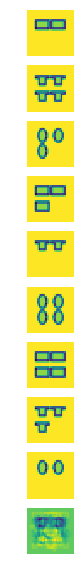

In [40]:
test_batch_size = 1
batch_size, data, latent_targets = None, None, None
test_loader = test_data.get_batch_iterator(test_batch_size)

for batch_idx, (data, labels) in enumerate(test_loader):
    batch_size = len(data)
    data, labels = torch.from_numpy(data).float(), torch.from_numpy(labels).long()
    if cuda:
        data, labels = data.cuda(), labels.cuda()
    data, labels = Variable(data), Variable(labels)
    optimizer.zero_grad()
    latent_predictions = model(data[:, :, :, :8])
    choices = data[:, :, :, 8:].permute(3, 0, 1, 2)
    indices = torch.from_numpy(np.arange(len(data))).long()
    if cuda:
        indices = indices.cuda()
    targets = choices[labels.data, indices].squeeze()
    # Get latent representations of targets
    targets = targets.view(batch_size, -1)
    latent_targets = model.autoencoder.encode(targets.cpu().data.numpy())
    # Convert to Torch variable
    latent_targets = torch.from_numpy(latent_targets).float()
    if cuda:
        latent_targets = latent_targets.cuda()
    latent_targets = Variable(latent_targets)
    break

setup = data[:, :, :, :8]
setup = setup.permute(3, 0, 1, 2).cpu().data.numpy()
setup = setup.reshape(-1, 28, 28)

originals = targets.cpu().data.numpy().reshape(-1, 28, 28)

decoded_predictions = model.autoencoder.decode(latent_predictions.cpu().data.numpy()).reshape(-1, 28, 28)

show_batch_of_images(np.concatenate([setup, originals, decoded_predictions]),
                     img_size=(test_batch_size, 10),
                     grid_size=(10, test_batch_size));

saving to out/img/qa_5_setup


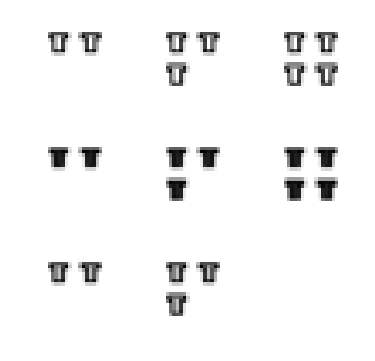

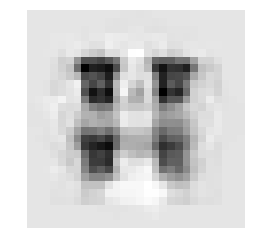

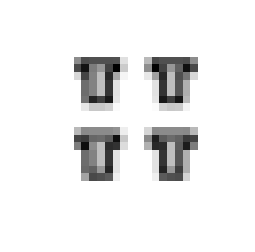

In [24]:
img_index = 5

res = np.concatenate([setup])
fig, axs = show_batch_of_images(res, img_size=(2,2), image_path=f'out/img/qa_{img_index}_setup', cmap='gray')

fig = plt.figure()
plt.imshow(decoded_predictions[0], cmap='gray')
plt.axis('off')
plt.savefig(f'out/img/qa_{img_index}_guess')

fig = plt.figure()
plt.imshow(originals[0], cmap='gray')
plt.axis('off')
plt.savefig(f'out/img/qa_{img_index}_true')

In [39]:
encoded = model.encoder(data)
eps = Variable(torch.randn(encoded.size())).cuda()
encoded_jittered = encoded + eps * 10

In [63]:
fig
plt.savefig('asd.jpg')

In [40]:
jittered_reconstruction = model.decoder(encoded_jittered)

In [47]:
start, end = data[5, :], data[3, :]
fades = start
for i in range(1, test_batch_size - 1):
    coeff = i / (test_batch_size - 1)
    new = end * coeff + start * (1 - coeff)
    fades = torch.cat((fades, new), 0)
fades = torch.cat((fades, end), 0) 

In [48]:
originals = data.view(test_batch_size, 28, 28).cpu().data.numpy()
reconstructions = output.view(test_batch_size, 28, 28).cpu().data.numpy()
jittered = jittered_reconstruction.view(test_batch_size, 28, 28).cpu().data.numpy()
faded = fades.view(test_batch_size, 28, 28).cpu().data.numpy()

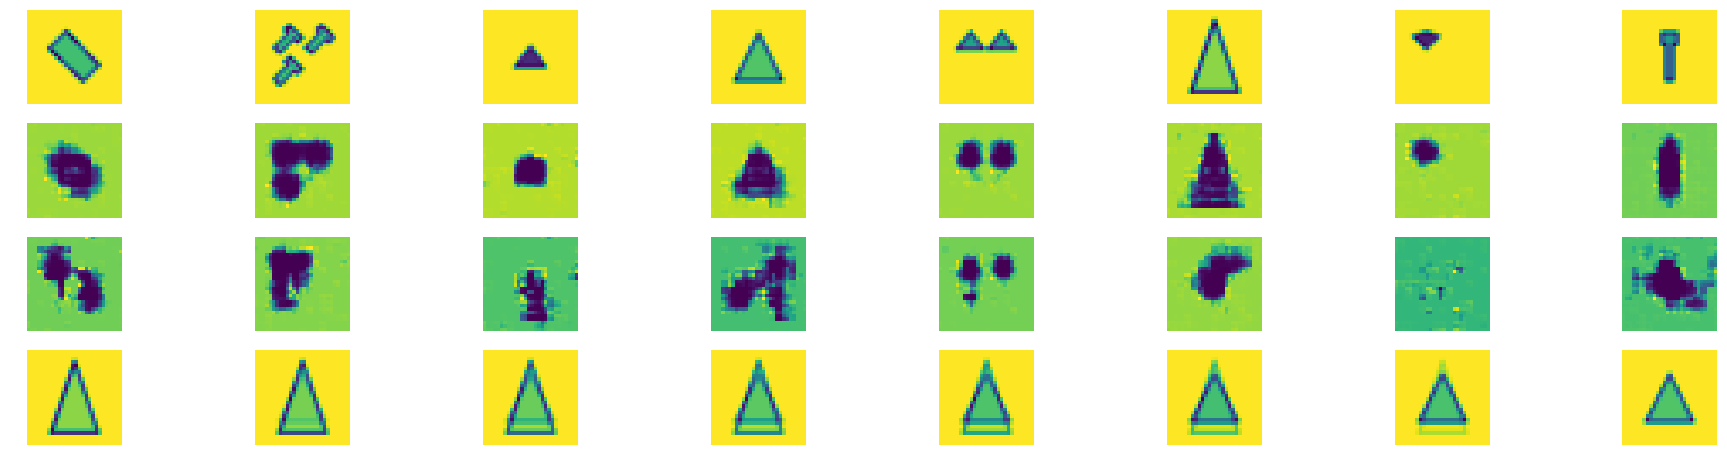

In [49]:
def show_batch_of_images(img_batch, img_size=(1,1), grid_size=None):
    # How many squares for a square grid that can fit all images
    if grid_size == None:
        grid_size = math.ceil(math.sqrt(len(img_batch)))
        grid_size = (grid_size, grid_size)
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(img_size[0] * grid_size[0], img_size[1] * grid_size[1]))
    # Turn the 2d array of axes to a 1d array
    axs = axs.flatten()
    for i, img in enumerate(img_batch):
        axs[i].imshow(img.reshape(28,28))
    # Do this separately in case the number of images we want to show is not a perfect square
    for i in range(grid_size[0] * grid_size[1]):
        axs[i].axis('off')
    plt.show()

show_batch_of_images(np.concatenate([originals, reconstructions, jittered, faded]), img_size=(test_batch_size, 1), grid_size=(4, test_batch_size))